In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import pyfolio
import statsmodels
import statsmodels.tsa.api as sm
import statsmodels.api as st
from statsmodels.tsa.stattools import adfuller, coint
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from itertools import combinations
from tinkoff.invest import Client
import requests
import apimoex
import gspread
from oauth2client.service_account import ServiceAccountCredentials
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings("ignore")
import time

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/kirillshmelev/opt/anaconda3/lib/python3.9/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


In [ ]:
def hist_price(ticker_list, start):
    dataframes = []  # List to store individual DataFrames

    with requests.Session() as session:
        for ticker in ticker_list:
            #temp = apimoex.get_market_candles(session, ticker, 24, start)
            temp = apimoex.get_market_candles(session, ticker, market='index', engine='stock', interval = 24, start = start)
            df = pd.DataFrame(temp)
            #df.set_index('begin', inplace=True)  # Set the datetime column as the index
            #df.rename(columns={'close': ticker}, inplace=True)  # Rename 'open' column to ticker symbol
            df.rename(columns={'begin': 'Date'}, inplace=True)  # Rename 'open' column to ticker symbol
            dataframes.append(df)
            df['Date'] = pd.to_datetime(df['Date'])
            print(f'done for {ticker}')
    # Concatenate individual DataFrames into a single DataFrame
    hist = pd.concat(dataframes, axis=1)

    return hist

In [ ]:
def calculate_vt(df, period=20, percentile = 50):
    vt_list = []
    for start in range(0, len(df), period):
        end = start + period
        if end > len(df):
            end = len(df)
        median_volatility = df['vol_10d'][start:end].median()
        vt_list.append(np.percentile(median_volatility, percentile))
    return vt_list

In [ ]:
bonds = pd.read_csv('gazp.csv', sep = ';')
si = pd.read_csv('si.csv', sep = ';')
cb = pd.read_csv('usdcb.csv', sep = ';')

In [ ]:
cb

In [ ]:
data = bonds

In [ ]:
data = pd.merge(
    bonds,
    si[['<DATE>' ,'<TIME>','<CLOSE>']],
    on = ['<DATE>' ,'<TIME>'],
    how ='left'
)

In [ ]:
data = pd.merge(
    data,
    cb[['<DATE>' ,'<CLOSE>']],
    on = ['<DATE>'],
    how ='left'
)

In [ ]:
cb

In [ ]:
data

In [ ]:
data.dropna(inplace = True)

In [ ]:
data

In [ ]:
data.rename(columns={'<CLOSE>_x': 'px'}, inplace = True)
data.rename(columns={'<CLOSE>_y': 'SI'}, inplace = True)
data.rename(columns={'<CLOSE>': 'cbr'}, inplace = True)

In [ ]:
data['SI'] = data['SI']/1000

In [ ]:
data['<DATE>'] <= 250319

In [ ]:
data['<DATE>'] = pd.to_datetime(data['<DATE>'],format='%y%m%d')

In [ ]:
data['SI'] = data['SI']/1000
data['<DATE>'] = pd.to_datetime(data['<DATE>'],format='%y%m%d')
cutoff_date = pd.to_datetime('250319', format='%y%m%d')  # 25-Mar-2019
end_date1 = pd.to_datetime('250319', format='%y%m%d')    # 25-Mar-2019
end_date2 = pd.to_datetime('250619', format='%y%m%d')    # 25-Jun-2019

# Calculate day differences
data['days'] = np.where(data['<DATE>'] <= cutoff_date,
                        (end_date1 - data['<DATE>']).dt.days,
                        (end_date2 - data['<DATE>']).dt.days)

In [ ]:
cutoff_date = pd.to_datetime('250319', format='%y%m%d')  # 25-Mar-2019
end_date1 = pd.to_datetime('250319', format='%y%m%d')    # 25-Mar-2019
end_date2 = pd.to_datetime('250619', format='%y%m%d')    # 25-Jun-2019

# Calculate day differences
data['days'] = np.where(data['<DATE>'] <= cutoff_date,
                        (end_date1 - data['<DATE>']).dt.days,
                        (end_date2 - data['<DATE>']).dt.days)

In [ ]:
data

In [ ]:
data['rate'] = (data['SI']/data['cbr'] - 1)/data['days'] * 365

In [ ]:
(100/95-1) / 60 * 365

In [ ]:
data[data['rate']<-14.9]

In [ ]:
data.iloc[3100:]

In [ ]:
data1 = data.iloc[3100:]

In [ ]:
data1['rate'].mean()

In [ ]:
data1['rpx'] = data1['px']*data1['cbr']

In [ ]:
data1['rpx'].plot()

In [ ]:
data1['rate'].plot()

In [ ]:
data1['rpx_hedged'] = data1['SI']/data1['cbr']*data1['px']

In [ ]:
data1['rpx_hedged'].plot()

In [ ]:
df = str_test(data)

In [ ]:
df['cum'] = df['pl'] + 1
# Calculate daily returns
df['daily_returns'] = df['cum'].pct_change()

# Calculate volatility (standard deviation of daily returns)
volatility = df['daily_returns'].std() * np.sqrt(252)

# Calculate volatility-adjusted return (Sharpe Ratio can be considered a form of this)
df['vol_adjusted_return'] = df['cum'] / volatility

# Calculate running maximum of cumulative returns
df['running_max'] = df['cum'].cummax()

# Calculate drawdown
df['drawdown'] = df['running_max'] - df['cum']

# Calculate maximum drawdown
max_drawdown = df['drawdown'].max()

In [ ]:
df.drawdown.plot()

In [ ]:
print('max drawdown: '  + str(max_drawdown))
print('vol adjusted return: ' + str(df['vol_adjusted_return'].iloc[-2]))


In [ ]:
plt.plot(df['norm_p']-1 , label='normalized price')
plt.plot(df['pl'], label='Perfomance')
plt.legend()
print('annualized perfomance:' + str(100 * ((1+df['pl'].iloc[-2]) ** (1/(len(df)/252)) - 1)))

In [ ]:
df[['pl','norm_p']]

In [ ]:
df['funding_long'].sum()

In [ ]:
df['position'].plot()

In [ ]:
df['cum'].plot()

In [ ]:
df.position.plot()

In [ ]:
df['funding_short'].sum()

In [ ]:
df['pl'].iloc[-2]

In [ ]:
(1+df['pl'].iloc[-2]) ** (1 / (len(df)/252))-1

In [ ]:
result = pd.DataFrame(columns = ['tickers', 'asset_perf', 'str_perf'])

In [ ]:
plt.plot(df['close'] , label='close')
plt.plot(df['ma_5'], label='ma_5')
plt.plot(df['ma_20'], label='ma_20')
plt.legend()
plt.show()

In [ ]:
today = datetime.today()
days_ago = today - timedelta(days=3000)
start = days_ago
data = hist_price(['IMOEX'], start)

In [ ]:
def tester(tickers):
    result = pd.DataFrame(columns = ['tickers', 'start', 'asset_perf', 'str_perf', 'diff'])
    excel_data = pd.ExcelFile('RC.xlsx')
    sheet_names = excel_data.sheet_names
    rate = excel_data.parse(sheet_names[0])
    rate.rename(columns={'6 месяцев': 'Rate', 'Дата': 'Date' }, inplace=True)
    rate['Rate'] = rate['Rate'] / 100
    columns_to_drop = ['Индекс', '1 месяц', '3 месяца']  
    rate = rate.drop(columns=columns_to_drop)
    for ticker in tickers:
        print(1)
        today = datetime.today()
        days_ago = today - timedelta(days=1000)
        start = days_ago.strftime("%Y-%m-%d")
        data = pd.DataFrame()
        print(2)
        data = hist_price([ticker], start)
        print(3)
        data['close_chg'] = data['close'].pct_change()
        data['vol_10d'] = data['close_chg'].rolling(window = 10).std() * np.sqrt(252) * 100
        data.reset_index(inplace = True)
        vt = calculate_vt(data)
        data['vt'] = 0
        for i, vt in enumerate(vt):
            start = (i+1) * 122
            end = start + 122
            if end > len(data):
                end = len(data)
            data.loc[start:end, 'vt'] = vt
        
        data = pd.merge(data, rate[['Date', 'Rate']], on='Date', how='left')
        df = str_test(data)
        ba_perf = df['norm_p'].iloc[-2] ** (1/(len(df)/252)) -1 
        str_perf = ((1+df['pl'].iloc[-2]) ** (1/(len(df)/252)) - 1)
        result.loc[len(result)] = [ticker, data['Date'][122], ba_perf, str_perf, str_perf - ba_perf]
        plt.plot(df['norm_p']-1 , label='normalized price')
        plt.plot(df['pl'], label='Perfomance')
        plt.title(ticker)
        plt.legend()
        plt.show()
        
        #time.sleep(1)
    return result

In [ ]:
tickers = ['SBMX', 'ALRS', 'CHMF', 'GAZP', 'GMKN', 'LKOH', 'MAGN', 'MGNT', 'NLMK', 'NVTK', 'PLZL', 'ROSN', 'SBER', 'SNGS', 'TATN', 'TCSG']

In [ ]:
res = tester(tickers)

In [ ]:
res

In [ ]:
df.iloc[120:]

In [ ]:
df['norm_p'].iloc[-2] ** (1/(len(df)/252)) -1 

In [ ]:
data

In [ ]:
df.position.plot()

In [ ]:
df.norm_p.plot()

In [ ]:
df.pl.plot()

In [ ]:
(df['norm_p']-1).plot()

In [ ]:
data['vol_10d'].plot()

In [ ]:
data['close'].plot()

In [ ]:
(abs(df.position - df.position.shift())).plot()

In [ ]:
(abs(df.position - df.position.shift())).sum()

In [ ]:
(283*0.0004)/(2000/365)

New try

In [ ]:
bonds = pd.read_csv('gazp.csv', sep = ';')
si = pd.read_csv('si.csv', sep = ';')
cb = pd.read_csv('usdcb.csv', sep = ';')

In [ ]:
cb

In [ ]:
data = pd.merge(
    bonds,
    si[['<DATE>' ,'<TIME>','<CLOSE>']],
    on = ['<DATE>' ,'<TIME>'],
    how ='left'
)

data = pd.merge(
    data,
    cb[['<DATE>' ,'<CLOSE>']],
    on = ['<DATE>'],
    how ='left'
)


data.rename(columns={'<CLOSE>_x': 'px'}, inplace = True)
data.rename(columns={'<CLOSE>_y': 'SI'}, inplace = True)
data.rename(columns={'<CLOSE>': 'cbr'}, inplace = True)

data['SI'] = data['SI']/1000
data['<DATE>'] = pd.to_datetime(data['<DATE>'],format='%y%m%d')
cutoff_date = pd.to_datetime('250319', format='%y%m%d')  # 25-Mar-2019
end_date1 = pd.to_datetime('250319', format='%y%m%d')    # 25-Mar-2019
end_date2 = pd.to_datetime('250619', format='%y%m%d')    # 25-Jun-2019

# Calculate day differences
data['days'] = np.where(data['<DATE>'] <= cutoff_date,
                        (end_date1 - data['<DATE>']).dt.days,
                        (end_date2 - data['<DATE>']).dt.days)

In [ ]:
data

In [ ]:
data['bond_returns'] = data['px'].pct_change()

In [ ]:
data['fx_returns'] = data['SI'].pct_change()

In [ ]:
data.dropna(inplace = True)

In [ ]:
import pandas as pd
import numpy as np
from scipy.signal import correlate


# Compute cross-correlation
cross_corr = correlate(data['bond_returns'], data['fx_returns'], mode='full')
lags = np.arange(-len(data)+1, len(data))
optimal_lag = lags[np.argmax(cross_corr)]  # Lag with highest correlation

print(f"Bonds lag FX by {optimal_lag} periods")

In [ ]:
(data['px']*data['SI']/data['cbr']).plot()

In [ ]:
from sklearn.linear_model import LinearRegression

# Fit bond returns vs. lagged FX returns
X = data['fx_returns'].shift(-optimal_lag).dropna().values.reshape(-1, 1)  # Lag-adjusted FX
y = data['bond_returns'].iloc[:len(X)].values  # Align bond returns

model = LinearRegression().fit(X, y)
data['predicted_bond'] = model.predict(X.reshape(-1, 1))
data['residuals'] = y - data['predicted_bond']  # "New" bond moves

# Plot residuals
data['residuals'].plot(title='Unexplained Bond Returns (Alpha)')

In [ ]:
std_dev = data['residuals'].std()
data['signal'] = np.where(data['residuals'] > std_dev, 1, 0)  # Buy bonds on "new" FX shocks

In [ ]:
data

In [ ]:
data['spread'] = data['bond_returns'] - data['fx_returns']
window = 20
data['spread_ma'] = data['spread'].rolling(window).mean()
data['spread_std'] = data['spread'].rolling(window).std()
data['upper_band'] = data['spread_ma'] + data['spread_std']
data['lower_band'] = data['spread_ma'] - data['spread_std']

In [ ]:
# 4. Entry Signals
data['signal'] = np.where(
    data['spread'] > data['upper_band'], 
    1,  # Buy bond, short futures
    np.where(
        data['spread'] < data['lower_band'], 
        -1,  # Sell bond, long futures
        0
    )
)

data['position'] = 0  # Initialize
active_position = 0
for i in range(1, len(data)):
    # Open new position if no active trade and signal exists
    if active_position == 0 and data['signal'].iloc[i] == 1:
        active_position = data['signal'].iloc[i]
    # Close position if spread converges or stop-loss hits
    elif active_position != 0:
        if (active_position == 1 and data['spread'].iloc[i] <= data['spread_ma'].iloc[i]) or 
          # (active_position == -1 and data['spread'].iloc[i] >= data['spread_ma'].iloc[i]) or \
           #(abs(data['spread'].iloc[i]) > 2 * data['spread_std'].iloc[i]):  # Stop-loss
            active_position = 0
    data['position'].iloc[i] = active_position

# 6. P&L Calculation
data['bond_pnl'] = data['px'].diff() * data['position'].shift(1)
data['futures_pnl'] = -data['SI'].diff() * data['position'].shift(1)  # Short hedge
data['total_pnl'] = data['bond_pnl'].fillna(0) + data['futures_pnl'].fillna(0)
data['cumulative_pnl'] = data['total_pnl'].cumsum()

# Results
print(data[['spread', 'position', 'total_pnl', 'cumulative_pnl']].tail(10))

In [ ]:
data[15:30]

In [ ]:
(data['SI']/data['CBR']).plot()

In [ ]:
data.columns

V.3

In [ ]:
data.dropna(inplace = True)

In [64]:
import pandas as pd
import numpy as np
from dataclasses import dataclass
from typing import Tuple

@dataclass
class StrategyParams:
    roll_std: int = 60           # minutes used for rolling σ
    z_entry: float = 2.0         # open position when |z| > z_entry
    z_exit: float = 0.5         # flatten when |z| < z_exit
    bond_notional_usd: int = 1000 # face value of bond per trade (USD)
    contract_size: int = 1_000   # USD value per MOEX USD/RUB futures contract


def compute_signals(df: pd.DataFrame, p: StrategyParams) -> pd.DataFrame:
    """Add residual, z‑score and trading signals to *df* (does not mutate input)."""
    out = df.copy()

    # Lagged values
    out['px_prev'] = out['px'].shift(1)
    out['SI_prev'] = out['SI'].shift(1)

    # Expected price given latest FX move
    out['P_exp'] = out['px_prev'] + out['px_prev'] * (
        (out['SI'] - out['SI_prev']) / out['cbr']
    )

    # Residual and rolling σ
    out['residual'] = out['px'] - out['P_exp']
    out['res_std'] = out['residual'].rolling(p.roll_std, min_periods=p.roll_std).std()
    out['z'] = out['residual'] / out['res_std']

    # Generate discrete bond position
    pos = 0
    positions = []
    for z in out['z']:
        if np.isnan(z):
            positions.append(pos)
            continue
        if pos == 0:
            if z > p.z_entry:
                pos = 0  # short bond, long USD via futures TURNED IT OFF
            elif z < -p.z_entry:
                pos = 1   # long bond, short USD via futures
        else:  # already in a trade
            if abs(z) < p.z_exit:
                pos = 0   # flatten
        positions.append(pos)

    out['pos_bond'] = positions
    out['pos_fx'] = -out['pos_bond'] * (p.bond_notional_usd / p.contract_size)
    return out


def pnl_from_positions(df: pd.DataFrame, p: StrategyParams) -> pd.DataFrame:
    """Compute minute‑by‑minute PnL streams (RUB) from positions."""
    out = df.copy()

    # Bond PnL: Δprice (% of par) × USD face × CBR fixing
    out['bond_pnl'] = (
        out['pos_bond'].shift(1) * out['px'].diff() / 100 * p.bond_notional_usd * out['cbr']
    )

    # Futures PnL: position (contracts) × Δprice (RUB per USD) × contract_size
    out['fx_pnl'] = out['pos_fx'].shift(1) * out['SI'].diff() * p.contract_size

    out['pnl'] = out['bond_pnl'].fillna(0) + out['fx_pnl'].fillna(0)
    out['cum_pnl'] = out['pnl'].cumsum()
    return out


def backtest(df: pd.DataFrame, params: StrategyParams = None) -> pd.DataFrame:
    """Full pipeline: compute signals, apply PnL accounting, return annotated DataFrame."""
    if params is None:
        params = StrategyParams()
    sig = compute_signals(df, params)
    res = pnl_from_positions(sig, params)
    return res


def performance_summary(res: pd.DataFrame) -> pd.Series:
    """Quick performance KPIs returned as a Series."""
    pnl = res['pnl']
    ann_factor = 252 * 60 * 6.5  # ≈ number of 1‑min bars per trading year (6.5h session)
    mean = pnl.mean() * ann_factor
    vol = pnl.std(ddof=0) * np.sqrt(ann_factor)
    sharpe = mean / vol if vol != 0 else np.nan
    max_dd = (res['cum_pnl'].cummax() - res['cum_pnl']).max()
    return pd.Series({
        'Total PnL (RUB)': res['cum_pnl'].iloc[-1],
        'Ann. Sharpe': sharpe,
        'Max drawdown (RUB)': max_dd,
        'Trades': res['pos_bond'].diff().abs().sum() / 2,
    })




In [78]:
si2

,<TICKER>,<PER>,<DATE>,<TIME>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>
0,SiM5202306,1,250320,90000,88597,88614,88530,88575,915
1,SiM5202306,1,250320,90100,88575,88692,88574,88649,435
2,SiM5202306,1,250320,90200,88638,88724,88637,88724,618
3,SiM5202306,1,250320,90300,88727,88790,88718,88788,785
4,SiM5202306,1,250320,90400,88788,88789,88597,88606,723
...,...,...,...,...,...,...,...,...,...
37227,SiM5202306,1,250521,230500,80932,80941,80931,80931,87
37228,SiM5202306,1,250521,230600,80932,80939,80929,80929,34
37229,SiM5202306,1,250521,230700,80929,80929,80925,80929,15
37230,SiM5202306,1,250521,230800,80926,80929,80926,80929,12


In [77]:
bonds2

,<TICKER>,<PER>,<DATE>,<TIME>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>
0,RU000A10B4K3,1,250321,144500,100.3800,103.9997,100.3800,101.5000,8
1,RU000A10B4K3,1,250321,144600,101.4273,101.4273,100.7162,100.9525,39
2,RU000A10B4K3,1,250321,144700,100.7162,100.7162,100.2593,100.7000,45
3,RU000A10B4K3,1,250321,144800,100.7044,100.7045,100.2660,100.6899,22
4,RU000A10B4K3,1,250321,144900,100.6000,100.6000,100.5977,100.5977,22
...,...,...,...,...,...,...,...,...,...
10070,RU000A10B4K3,1,250521,183900,101.6990,101.7000,101.6990,101.7000,29
10071,RU000A10B4K3,1,250521,184500,101.7000,101.7000,101.7000,101.7000,14
10072,RU000A10B4K3,1,250521,184700,101.7000,101.7000,101.7000,101.7000,3
10073,RU000A10B4K3,1,250521,184800,101.7000,101.7000,101.7000,101.7000,9


In [3]:
bonds2 = pd.read_csv('gmkn.csv', sep = ';')
si2 = pd.read_csv('SiM.csv', sep = ';')
cb2 = pd.read_csv('USDCB_2.csv', sep = ';')

data2 = pd.merge(
    bonds2,
    si2[['<DATE>' ,'<TIME>','<CLOSE>']],
    on = ['<DATE>' ,'<TIME>'],
    how ='left'
)

data2 = pd.merge(
    data2,
    cb2[['<DATE>' ,'<CLOSE>']],
    on = ['<DATE>'],
    how ='left'
)


data2.rename(columns={'<CLOSE>_x': 'px'}, inplace = True)
data2.rename(columns={'<CLOSE>_y': 'SI'}, inplace = True)
data2.rename(columns={'<CLOSE>': 'cbr'}, inplace = True)

data2['SI'] = data2['SI']/1000
data2['<DATE>'] = pd.to_datetime(data2['<DATE>'],format='%y%m%d')
data2['cbr'].ffill(inplace = True)


In [40]:
data2['cbr'].ffill(inplace = True)

<Axes: >

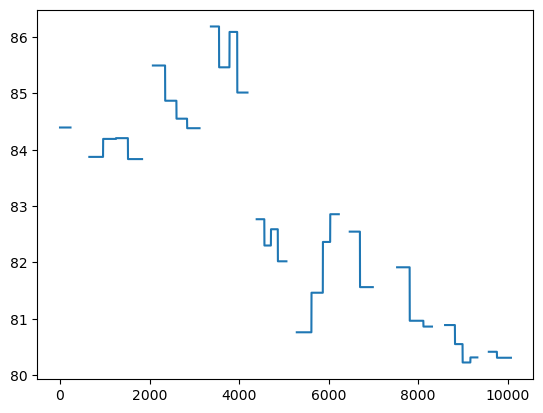

In [70]:
if __name__ == "__main__":
    # ---------------------------------------------------------------------
    # Example usage with synthetic data -----------------------------------
    # ---------------------------------------------------------------------


    results = backtest(data2)
    print(performance_summary(results))

Total PnL (RUB)       29148.331385
Ann. Sharpe              14.910934
Max drawdown (RUB)     1234.859797
Trades                  216.000000
dtype: float64


In [68]:
data2['cbr'].iloc[1990:2010]

1990    83.8347
1991    83.8347
1992    83.8347
1993    83.8347
1994    83.8347
1995    83.8347
1996    83.8347
1997    83.8347
1998    83.8347
1999    83.8347
2000    83.8347
2001    83.8347
2002    83.8347
2003    83.8347
2004    83.8347
2005    83.8347
2006    83.8347
2007    83.8347
2008    83.8347
2009    83.8347
Name: cbr, dtype: float64

In [71]:
results['z'].iloc[1990:2010]

1990   NaN
1991   NaN
1992   NaN
1993   NaN
1994   NaN
1995   NaN
1996   NaN
1997   NaN
1998   NaN
1999   NaN
2000   NaN
2001   NaN
2002   NaN
2003   NaN
2004   NaN
2005   NaN
2006   NaN
2007   NaN
2008   NaN
2009   NaN
Name: z, dtype: float64

In [72]:
results.drop(['<PER>','<OPEN>','<HIGH>','<LOW>','<VOL>'], axis =1 , inplace = True)

In [75]:
results[1950:2000]

,<TICKER>,<DATE>,<TIME>,px,SI,cbr,px_prev,SI_prev,P_exp,residual,res_std,z,pos_bond,pos_fx,bond_pnl,fx_pnl,pnl,cum_pnl
1950,RU000A10B4K3,2025-03-31,132200,102.2344,89.456,83.8347,102.0035,89.395,102.077720,0.156680,0.151782,1.032271,0,0.0,0.0,0.0,0.0,6756.896393
1951,RU000A10B4K3,2025-03-31,132600,102.2344,89.413,83.8347,102.2344,89.456,102.181963,0.052437,0.151812,0.345410,0,0.0,0.0,-0.0,0.0,6756.896393
1952,RU000A10B4K3,2025-03-31,132800,102.2345,89.415,83.8347,102.2344,89.413,102.236839,-0.002339,0.151812,-0.015407,0,0.0,0.0,0.0,0.0,6756.896393
1953,RU000A10B4K3,2025-03-31,133200,102.2344,89.250,83.8347,102.2345,89.415,102.033286,0.201114,0.152664,1.317359,0,0.0,-0.0,-0.0,-0.0,6756.896393
1954,RU000A10B4K3,2025-03-31,133500,102.1999,89.138,83.8347,102.2344,89.250,102.097819,0.102081,0.152541,0.669206,0,0.0,-0.0,-0.0,-0.0,6756.896393
1955,RU000A10B4K3,2025-03-31,133700,102.0101,89.140,83.8347,102.1999,89.138,102.202338,-0.192238,0.154723,-1.242464,0,0.0,-0.0,0.0,0.0,6756.896393
1956,RU000A10B4K3,2025-03-31,134100,102.0100,89.225,83.8347,102.0101,89.140,102.113528,-0.103528,0.155351,-0.666415,0,0.0,-0.0,0.0,0.0,6756.896393
1957,RU000A10B4K3,2025-03-31,134200,102.0100,89.197,83.8347,102.0100,89.225,101.975930,0.034070,0.155379,0.219273,0,0.0,0.0,-0.0,0.0,6756.896393
1958,RU000A10B4K3,2025-03-31,134500,102.1798,89.105,83.8347,102.0100,89.197,101.898054,0.281746,0.159206,1.769687,0,0.0,0.0,-0.0,0.0,6756.896393
1959,RU000A10B4K3,2025-03-31,134700,102.1797,89.160,83.8347,102.1798,89.105,102.246835,-0.067135,0.159570,-0.420727,0,0.0,-0.0,0.0,0.0,6756.896393


In [ ]:
117*0.00025*1000*82

In [ ]:
results.drop(['<TICKER>','<PER>','<OPEN>','<HIGH>','<LOW>','<VOL>', 'days'], axis = 1 , inplace = True)

In [79]:
BOND_TICKER = "RU000A10B4K3"      # substituted eurobond ISIN or MOEX ticker
BOND_ENGINE = "stock"
BOND_MARKET = "bonds"
BOND_BOARD  = "TQCB"              # change if needed

FUT_TICKER  = "SiM5"              # nearest USD/RUB futures contract
FUT_ENGINE  = "futures"
FUT_MARKET  = "forts"
FUT_BOARD   = "RFUD"

NameError: name 'session' is not defined

In [82]:
from __future__ import annotations

import time
from datetime import datetime, timedelta, timezone
from pathlib import Path
from typing import Literal

import numpy as np
import pandas as pd
import requests
from apimoex import ISSClient  # noqa: F401 – just to remind user the dependency

# -----------------------------------------------------------------------------
# CONFIGURATION
# -----------------------------------------------------------------------------
# ---- Instruments -------------------------------------------------------------
BOND_TICKER = "RU000A10B4K3"      # substituted eurobond ISIN or MOEX ticker
BOND_ENGINE = "stock"
BOND_MARKET = "bonds"
BOND_BOARD  = "TQCB"              # change if needed

FUT_TICKER  = "SiM5"              # nearest USD/RUB futures contract
FUT_ENGINE  = "futures"
FUT_MARKET  = "forts"
FUT_BOARD   = "RFUD"

CONTRACT_SIZE_USD = 1000          # MOEX standard USD futures size
BOND_NOTIONAL_USD = 1000            # 1 bond = 100 USD face

# ---- Position sizing ---------------------------------------------------------
BOND_UNITS_PER_TRADE = 1          # trade 10 bonds per signal
FUT_UNITS_PER_TRADE  = 1 #round(BOND_UNITS_PER_TRADE * BOND_NOTIONAL_USD / CONTRACT_SIZE_USD) or 1

# ---- Signal parameters -------------------------------------------------------
ROLL_STD_MINUTES = 60              # window for residual std‑dev
Z_ENTRY = 2.0                      # open when |z| > entry
Z_EXIT  = 0.5                      # close when |z| < exit

# ---- Transaction costs (proportional, one‑way) -------------------------------
BOND_TC = 0.0002                  # 10 bp per bond trade (each side)
FX_TC   = 0.0002                  #  1 bp per futures trade (each side)

# ---- Persistence -------------------------------------------------------------
DATA_DIR = Path("./live_data")
DATA_DIR.mkdir(exist_ok=True)
TRADES_CSV  = DATA_DIR / "trades_log.csv"
HISTORY_CSV = DATA_DIR / "minute_history.csv"

# -----------------------------------------------------------------------------
# Helper functions – MOEX ISS REST calls
# -----------------------------------------------------------------------------

def _last_price(session: requests.Session, *, engine: str, market: str, board: str, ticker: str) -> float:
    """Return the latest **LAST** price for *ticker* via MOEX ISS JSON."""
    url = (
        f"https://iss.moex.com/iss/engines/{engine}/markets/{market}/boards/{board}/"
        f"securities/{ticker}.json"
    )
    params = {"iss.only": "marketdata"}
    r = session.get(url, params=params, timeout=5)
    r.raise_for_status()
    data = r.json()
    try:
        idx_last = data["marketdata"][0].index("LAST")
        last_price = data["marketdata"][1][idx_last]
    except (ValueError, IndexError):
        raise RuntimeError(f"Could not parse LAST price for {ticker}")
    return float(last_price) if last_price is not None else np.nan


def _cbr_fix(session: requests.Session, date: datetime) -> float:
    """Return the CBR USD/RUB official fixing for *date* (RUB per USD).
    Cached locally (one tiny txt file per day).
    """
    cache_file = DATA_DIR / f"cbr_{date.strftime('%Y%m%d')}.txt"
    if cache_file.exists():
        return float(cache_file.read_text())
    # Same‑day value (after ~15:00 Moscow) is available from XML_daily service
    date_str = date.strftime("%d/%m/%Y")
    url = "https://www.cbr.ru/scripts/XML_daily.asp"
    r = session.get(url, params={"date_req": date_str}, timeout=5)
    r.raise_for_status()
    import xml.etree.ElementTree as ET

    root = ET.fromstring(r.content)
    fx_val = None
    for val in root.findall("Valute"):
        if val.find("CharCode").text == "USD":
            fx_val = val.find("Value").text.replace(",", ".")
            break
    if fx_val is None:
        raise RuntimeError("USD not found in CBR feed")
    cache_file.write_text(fx_val)
    return float(fx_val)

# -----------------------------------------------------------------------------
# Trading engine
# -----------------------------------------------------------------------------
class LiveBasisTrader:
    """One instance manages the intraday history, signal, and virtual P&L."""

    def __init__(self):
        self.history: pd.DataFrame = pd.DataFrame(
            columns=[
                "bond", "fut", "cbr", "residual", "z", "pos", "pnl", "cum_pnl",
            ]
        )
        self.pos: int = 0          # +1 long package, -1 short, 0 flat
        self.cum_pnl: float = 0.0
        # Reload previous session if files exist
        if HISTORY_CSV.exists():
            self.history = pd.read_csv(HISTORY_CSV, parse_dates=["datetime"], index_col="datetime")
            if not self.history.empty:
                self.pos = int(self.history["pos"].iloc[-1])
                self.cum_pnl = float(self.history["cum_pnl"].iloc[-1])
        if not TRADES_CSV.exists():
            TRADES_CSV.write_text(
                "datetime,action,bond_price,fut_price,qty_bond,qty_fut,cost_rub,cum_pnl\n"
            )

    # ------------------------------------------------------------------
    # Data fetch per minute
    # ------------------------------------------------------------------
    def fetch_prices(self, session: requests.Session) -> tuple[float, float, float]:
        bond_px = _last_price(
            session,
            engine=BOND_ENGINE,
            market=BOND_MARKET,
            board=BOND_BOARD,
            ticker=BOND_TICKER,
        )
        fut_px = _last_price(
            session,
            engine=FUT_ENGINE,
            market=FUT_MARKET,
            board=FUT_BOARD,
            ticker=FUT_TICKER,
        )
        cbr_fix = _cbr_fix(session, datetime.now(timezone.utc).astimezone())
        return bond_px, fut_px, cbr_fix

    # ------------------------------------------------------------------
    # Signal computation
    # ------------------------------------------------------------------
    def compute_signal(self, bond_px: float, fut_px: float) -> tuple[float, float]:
        """Compute residual and z‑score versus previous minute."""
        if self.history.empty:
            residual = 0.0
            z = 0.0
        else:
            prev_price = self.history["bond"].iloc[-1]
            prev_fut = self.history["fut"].iloc[-1]
            # Expected bond price given latest FX move (positive correlation)
            p_exp = prev_price * fut_px / prev_fut
            residual = bond_px - p_exp
            window = self.history["residual"].tail(ROLL_STD_MINUTES).std(ddof=0)
            z = residual / window if window and window > 0 else 0.0
        return residual, z

    # ------------------------------------------------------------------
    # Trading decision
    # ------------------------------------------------------------------
    def decide_trade(self, z: float) -> Literal["open_long", "open_short", "close", "hold"]:
        """Pure state machine based on current position and z‑score."""
        if self.pos == 0:
            if z < -Z_ENTRY:
                return "open_long"    # bond cheap ⇒ buy bond, sell futures
            if z > Z_ENTRY:
                return "open_short"   # bond rich  ⇒ sell bond, buy futures
        elif self.pos == 1:  # currently long package
            if z >= -Z_EXIT:
                return "close"
        elif self.pos == -1:  # currently short package
            if z <= Z_EXIT:
                return "close"
        return "hold"

    # ------------------------------------------------------------------
    # Execute (paper) trade
    # ------------------------------------------------------------------
    def execute_trade(
        self,
        action: Literal["open_long", "open_short", "close"],
        bond_px: float,
        fut_px: float,
        cbr: float,
        ts: datetime,
    ) -> None:
        # Determine quantity for this trade
        qty_bond: int
        qty_fut: int
        cost_rub: float = 0.0

        if action == "open_long":
            qty_bond = +BOND_UNITS_PER_TRADE
            qty_fut  = -FUT_UNITS_PER_TRADE  # sell futures
            self.pos = 1
        elif action == "open_short":
            qty_bond = -BOND_UNITS_PER_TRADE
            qty_fut  = +FUT_UNITS_PER_TRADE  # buy futures
            self.pos = -1
        elif action == "close":
            # close the whole position
            qty_bond = -self.pos * BOND_UNITS_PER_TRADE
            qty_fut  = self.pos * FUT_UNITS_PER_TRADE
            self.pos = 0
        else:
            return  # nothing to do

        # Transaction cost in RUB
        bond_notional_rub = abs(qty_bond) * bond_px / 100 * BOND_NOTIONAL_USD * cbr
        fut_notional_rub  = abs(qty_fut)  * fut_px * CONTRACT_SIZE_USD
        cost_rub += bond_notional_rub * BOND_TC
        cost_rub += fut_notional_rub  * FX_TC

        # Realised P&L (approx) – we tag cost only; unrealised handled each minute
        self.cum_pnl -= cost_rub

        # Log trade
        with TRADES_CSV.open("a") as f:
            f.write(
                f"{ts.isoformat(timespec='seconds')},{action},{bond_px},{fut_px},"
                f"{qty_bond},{qty_fut},{cost_rub:.2f},{self.cum_pnl:.2f}\n"
            )

    # ------------------------------------------------------------------
    # Per‑minute book‑keeping & run loop
    # ------------------------------------------------------------------
    def mark_to_market(self, bond_px: float, fut_px: float, cbr: float) -> float:
        """Return unrealised P&L on current position (RUB)."""
        unrealised = 0.0
        if self.pos != 0:
            # Bond leg
            bond_val_rub = (
                self.pos * BOND_UNITS_PER_TRADE * bond_px / 100 * BOND_NOTIONAL_USD * cbr
            )
            # Futures leg (market value = position * contract size * price with sign)
            fut_val_rub = (
                -self.pos * FUT_UNITS_PER_TRADE * fut_px * CONTRACT_SIZE_USD
            )
            unrealised = bond_val_rub + fut_val_rub
        return unrealised

    def run_forever(self):
        """Main loop – align to round minutes, run until interrupted."""
        session = requests.Session()
        try:
            while True:
                ts = datetime.now(timezone.utc).astimezone()
                # Align to start of the next minute
                sleep_sec = 60 - ts.second - ts.microsecond / 1_000_000
                time.sleep(max(sleep_sec, 0))
                ts = datetime.now(timezone.utc).astimezone()

                bond_px, fut_px, cbr = self.fetch_prices(session)
                residual, z = self.compute_signal(bond_px, fut_px)

                action = self.decide_trade(z)
                if action != "hold":
                    self.execute_trade(action, bond_px, fut_px, cbr, ts)

                unrealised = self.mark_to_market(bond_px, fut_px, cbr)
                pnl_this_min = unrealised  # realised already in cum_pnl
                self.cum_pnl_marked = self.cum_pnl + unrealised

                # Append to history DataFrame
                self.history.loc[ts] = {
                    "bond": bond_px,
                    "fut": fut_px,
                    "cbr": cbr,
                    "residual": residual,
                    "z": z,
                    "pos": self.pos,
                    "pnl": pnl_this_min,
                    "cum_pnl": self.cum_pnl_marked,
                }

                # Persist every minute
                self.history.to_csv(HISTORY_CSV)

                # Optional: print heartbeat
                print(
                    f"[{ts:%Y-%m-%d %H:%M}] bond={bond_px:.3f} fut={fut_px:.2f} z={z:+.2f} "
                    f"pos={self.pos:+d} cum_pnl={self.cum_pnl_marked:,.0f} RUB  action={action}"
                )
        except KeyboardInterrupt:
            print("Interrupted – saving state…")
            self.history.to_csv(HISTORY_CSV)



In [86]:
"""Return the latest **LAST** price for *ticker* via MOEX ISS JSON."""
url = (
    f"https://iss.moex.com/iss/engines/stock/markets/bonds/boards/TQCB/"
    f"securities/RU000A10B4K3.json"
)
params = {"iss.only": "marketdata"}
r = requests.get(url, params=params, timeout=5)
r.raise_for_status()
data = r.json()
try:
    idx_last = data["marketdata"][0].index("LAST")
    last_price = data["marketdata"][1][idx_last]
except (ValueError, IndexError):
    raise RuntimeError(f"Could not parse LAST price for {ticker}")
return float(last_price) if last_price is not None else np.nan

KeyError: 0

In [112]:
data['marketdata']['columns']

['SECID',
 'BID',
 'BIDDEPTH',
 'OFFER',
 'OFFERDEPTH',
 'SPREAD',
 'BIDDEPTHT',
 'OFFERDEPTHT',
 'OPEN',
 'LOW',
 'HIGH',
 'LAST',
 'LASTCHANGE',
 'LASTCHANGEPRCNT',
 'QTY',
 'VALUE',
 'YIELD',
 'VALUE_USD',
 'WAPRICE',
 'LASTCNGTOLASTWAPRICE',
 'WAPTOPREVWAPRICEPRCNT',
 'WAPTOPREVWAPRICE',
 'YIELDATWAPRICE',
 'YIELDTOPREVYIELD',
 'CLOSEYIELD',
 'CLOSEPRICE',
 'MARKETPRICETODAY',
 'MARKETPRICE',
 'LASTTOPREVPRICE',
 'NUMTRADES',
 'VOLTODAY',
 'VALTODAY',
 'VALTODAY_USD',
 'BOARDID',
 'TRADINGSTATUS',
 'UPDATETIME',
 'DURATION',
 'NUMBIDS',
 'NUMOFFERS',
 'CHANGE',
 'TIME',
 'HIGHBID',
 'LOWOFFER',
 'PRICEMINUSPREVWAPRICE',
 'LASTBID',
 'LASTOFFER',
 'LCURRENTPRICE',
 'LCLOSEPRICE',
 'MARKETPRICE2',
 'OPENPERIODPRICE',
 'SEQNUM',
 'SYSTIME',
 'VALTODAY_RUR',
 'IRICPICLOSE',
 'BEICLOSE',
 'CBRCLOSE',
 'YIELDTOOFFER',
 'YIELDLASTCOUPON',
 'TRADINGSESSION',
 'CALLOPTIONYIELD',
 'CALLOPTIONDURATION']

In [110]:
data['marketdata']['data']

[['RU000A10B4K3',
  None,
  None,
  None,
  None,
  0,
  0,
  0,
  103.1,
  101.8,
  103.1,
  102.4663,
  -0.0001,
  0,
  2,
  16343.99,
  5.04,
  204.93,
  102.3116,
  0.5574,
  0.4,
  0.4027,
  5.24,
  -0.55,
  0,
  None,
  102.3116,
  101.9048,
  0.75,
  531,
  10377,
  84672747,
  1061687,
  'TQCB',
  'N',
  '19:36:30',
  0,
  None,
  None,
  0.7663,
  '18:48:28',
  None,
  None,
  0.5574,
  None,
  None,
  102.4663,
  102.4663,
  102.3116,
  103.1,
  20250522195134,
  '2025-05-22 19:51:34',
  84672747,
  None,
  None,
  None,
  4.9247,
  None,
  None,
  None,
  None]]

In [111]:
pd.DataFrame(data['marketdata']['data'])

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,RU000A10B4K3,None,None,None,None,0,0,0,103.1,101.8,...,2025-05-22 19:51:34,84672747,None,None,None,4.9247,None,None,None,None


In [342]:
BOND_TICKER = "RU000A10B4K3"
BOND_ENGINE = "stock"
BOND_MARKET = "bonds"
BOND_BOARD  = "TQCB"

FUT_TICKER  = "SiM5"
FUT_ENGINE  = "futures"
FUT_MARKET  = "forts"
FUT_BOARD   = "RFUD"

In [314]:
def _quote(engine: str, market: str, board: str, ticker: str) -> tuple[float,float,float]:
    """Return (last, bid, ask) prices as floats."""
    url = (f"https://iss.moex.com/iss/engines/{engine}/markets/{market}/boards/{board}/securities/{ticker}.json")
    params = {"iss.only": "marketdata"}
    r = requests.get(url, params=params, timeout=5)
    r.raise_for_status()
    data = r.json()["marketdata"]
    cols, vals = data['columns'], data['data']
    df = pd.DataFrame(vals, columns = cols)
    return df["LAST"].iloc[-1], df["BID"].iloc[-1], df["OFFER"].iloc[-1]

In [303]:
a,b,c = _quote(engine = BOND_ENGINE, market = BOND_MARKET, board = BOND_BOARD, ticker = BOND_TICKER)

In [304]:
a

102.4997

In [319]:
d['LAST'].item()

102.4997

In [346]:
# -*- coding: utf-8 -*-
"""moex_live_basis.py – *One‑sided* live paper‑trading bot
==========================================================
*Only* trade **long substituted eurobond / short USD‑RUB futures**.
Entry/exit still driven by z‑score of last‑trade prices, *but* fills are done
on realistic **ask/bid** prices:
    • Open package → buy bond at **ask**  &  sell futures at **bid**
    • Close package → sell bond at **bid** &  buy  futures at **ask**

All previous functionality (minute loop, transaction‑costs, logs) preserved.
"""
from __future__ import annotations

import time
from datetime import datetime, timedelta, timezone
from pathlib import Path
from typing import Literal

import numpy as np
import pandas as pd
import requests

# -----------------------------------------------------------------------------
# CONFIGURATION
# -----------------------------------------------------------------------------
BOND_TICKER = "RU000A10B4K3"
BOND_ENGINE = "stock"
BOND_MARKET = "bonds"
BOND_BOARD  = "TQCB"

FUT_TICKER  = "SiM5"
FUT_ENGINE  = "futures"
FUT_MARKET  = "forts"
FUT_BOARD   = "RFUD"

CONTRACT_SIZE_USD = 1000
BOND_NOTIONAL_USD = 1000

BOND_UNITS_PER_TRADE = 1
FUT_UNITS_PER_TRADE  = round(BOND_UNITS_PER_TRADE * BOND_NOTIONAL_USD / CONTRACT_SIZE_USD) or 1

ROLL_STD_MINUTES = 60
Z_ENTRY = 2.0   # open when z < -2
Z_EXIT  = 0.5   # close when z > -0.5

BOND_TC = 0.0002  # 2 bp one‑way
FX_TC   = 0.0002  #  2 bp one‑way

DATA_DIR = Path("./live_data")
DATA_DIR.mkdir(exist_ok=True)
TRADES_CSV  = DATA_DIR / "trades_log.csv"
HISTORY_CSV = DATA_DIR / "minute_history.csv"

# -----------------------------------------------------------------------------
# Helper – MOEX ISS
# -----------------------------------------------------------------------------

def _quote(engine: str, market: str, board: str, ticker: str) -> tuple[float,float,float]:
    """Return (last, bid, ask) prices as floats."""
    url = (f"https://iss.moex.com/iss/engines/{engine}/markets/{market}/boards/{board}/securities/{ticker}.json")
    params = {"iss.only": "marketdata"}
    r = requests.get(url, params=params, timeout=5)
    r.raise_for_status()
    data = r.json()["marketdata"]
    cols, vals = data['columns'], data['data']
    df = pd.DataFrame(vals, columns = cols)
    print(df)
    return df["LAST"].iloc[-1], df["BID"].iloc[-1], df["OFFER"].iloc[-1]
   


def _cbr_fix(date: datetime) -> float:
    cache = DATA_DIR / f"cbr_{date:%Y%m%d}.txt"
    if cache.exists():
        return float(cache.read_text())
    url = "https://www.cbr.ru/scripts/XML_daily.asp"
    r = requests.get(url, params={"date_req": date.strftime("%d/%m/%Y")}, timeout=5)
    r.raise_for_status()
    import xml.etree.ElementTree as ET
    for val in ET.fromstring(r.content).findall("Valute"):
        if val.find("CharCode").text == "USD":
            fx = val.find("Value").text.replace(",", ".")
            cache.write_text(fx)
            return float(fx)
    raise RuntimeError("USD not in CBR feed")

# -----------------------------------------------------------------------------
class LiveBasisTrader:
    def __init__(self):
        self.history = pd.DataFrame(columns=[
            "bond_mid", "fut_mid", "cbr", "residual", "z", "pos", "cum_pnl"
        ])
        self.pos = 0  # 0 flat, 1 long‑package only
        self.cum_pnl = 0.0
        if HISTORY_CSV.exists():
            self.history = pd.read_csv(HISTORY_CSV, parse_dates=["datetime"], index_col="datetime")
            if not self.history.empty:
                self.pos = int(self.history["pos"].iloc[-1])
                self.cum_pnl = float(self.history["cum_pnl"].iloc[-1])
        if not TRADES_CSV.exists():
            TRADES_CSV.write_text("datetime,action,bond_px,fut_px,cost_rub,cum_pnl\n")

    # ------------------------------------------------------------------
    def fetch(self, session: requests.Session):
        bond_last, bond_bid, bond_ask = _quote(engine=BOND_ENGINE, market=BOND_MARKET, board=BOND_BOARD, ticker=BOND_TICKER)
        fut_last, fut_bid, fut_ask   = _quote(engine=FUT_ENGINE,  market=FUT_MARKET,  board=FUT_BOARD,  ticker=FUT_TICKER)
        cbr = _cbr_fix(datetime.now(timezone.utc).astimezone())
        return (bond_last, bond_bid, bond_ask, fut_last, fut_bid, fut_ask, cbr)

    # ------------------------------------------------------------------
    def compute_z(self, bond_last: float, fut_last: float):
        if self.history.empty:
            return 0.0, 0.0
        prev_bond = self.history["bond_mid"].iloc[-1]
        prev_fut  = self.history["fut_mid"].iloc[-1]
        p_exp = prev_bond * fut_last / prev_fut
        residual = bond_last - p_exp
        std = self.history["residual"].tail(ROLL_STD_MINUTES).std(ddof=0)
        z = residual / std if std and std>0 else 0.0
        return residual, z

    # ------------------------------------------------------------------
    def decide(self, z: float) -> Literal["open_long","close","hold"]:
        if self.pos == 0 and z < -Z_ENTRY:
            return "open_long"
        if self.pos == 1 and z > -Z_EXIT:
            return "close"
        return "hold"

    # ------------------------------------------------------------------
    def exec_trade(self, action: Literal["open_long","close"], bond_bid:float, bond_ask:float, fut_bid:float, fut_ask:float, cbr:float, ts:datetime):
        if action == "open_long":
            bond_px = bond_ask  # we pay ask
            fut_px  = fut_bid   # we hit bid to sell
            cost = (BOND_UNITS_PER_TRADE * bond_px/100 * BOND_NOTIONAL_USD * cbr) * BOND_TC
            cost += (FUT_UNITS_PER_TRADE  * fut_px * CONTRACT_SIZE_USD) * FX_TC
            self.cum_pnl -= cost
            self.pos = 1
        elif action == "close":
            bond_px = bond_bid  # we get bid when selling
            fut_px  = fut_ask   # we pay ask when buying back
            cost = (BOND_UNITS_PER_TRADE * bond_px/100 * BOND_NOTIONAL_USD * cbr) * BOND_TC
            cost += (FUT_UNITS_PER_TRADE  * fut_px * CONTRACT_SIZE_USD) * FX_TC
            # Realise PnL since opening leg – we mark to market using mid, so here only cost
            self.cum_pnl -= cost
            self.pos = 0
        else:
            return
        with TRADES_CSV.open("a") as f:
            f.write(f"{ts.isoformat(timespec='seconds')},{action},{bond_px},{fut_px},{cost:.2f},{self.cum_pnl:.2f}\n")

    # ------------------------------------------------------------------
    def mark(self, bond_mid:float, fut_mid:float, cbr:float):
        if self.pos==0:
            return 0.0
        bond_val = BOND_UNITS_PER_TRADE * bond_mid/100 * BOND_NOTIONAL_USD * cbr
        fut_val  = -FUT_UNITS_PER_TRADE * fut_mid * CONTRACT_SIZE_USD
        return bond_val + fut_val

    # ------------------------------------------------------------------
    def loop(self):
        sess = requests.Session()
        try:
            while True:
                ts = datetime.now(timezone.utc).astimezone()
                time.sleep(max(0, 60 - ts.second - ts.microsecond/1e6))
                ts = datetime.now(timezone.utc).astimezone()

                (bond_last, bond_bid, bond_ask,
                 fut_last, fut_bid, fut_ask, cbr) = self.fetch(sess)
                bond_mid = (bond_bid + bond_ask)/2
                fut_mid  = (fut_bid  + fut_ask)/2

                residual, z = self.compute_z(bond_last, fut_last)
                action = self.decide(z)
                if action != "hold":
                    self.exec_trade(action, bond_bid, bond_ask, fut_bid, fut_ask, cbr, ts)

                mtm = self.mark(bond_mid, fut_mid, cbr)
                cum = self.cum_pnl + mtm

                self.history.loc[ts] = {
                    "bond_mid": bond_mid,
                    "fut_mid": fut_mid,
                    "cbr": cbr,
                    "residual": residual,
                    "z": z,
                    "pos": self.pos,
                    "cum_pnl": cum,
                }
                self.history.to_csv(HISTORY_CSV)
                print(f"[{ts:%Y-%m-%d %H:%M}] z={z:+.2f} pos={self.pos} cum={cum:,.0f} action={action}")
        except KeyboardInterrupt:
            self.history.to_csv(HISTORY_CSV)
            print("Stopped.")

# -----------------------------------------------------------------------------
if __name__ == "__main__":
    LiveBasisTrader().loop()


          SECID   BID BIDDEPTH OFFER OFFERDEPTH  SPREAD  BIDDEPTHT  \
0  RU000A10B4K3  None     None  None       None       0          0   

   OFFERDEPTHT      OPEN       LOW  ...              SYSTIME  VALTODAY_RUR  \
0            0  102.4885  102.0121  ...  2025-05-23 19:49:33      55291228   

   IRICPICLOSE  BEICLOSE  CBRCLOSE  YIELDTOOFFER  YIELDLASTCOUPON  \
0         None      None      None        4.8571             None   

   TRADINGSESSION  CALLOPTIONYIELD  CALLOPTIONDURATION  
0            None             None                None  

[1 rows x 61 columns]
  SECID BOARDID   BID OFFER  SPREAD   OPEN   HIGH    LOW   LAST  QUANTITY  \
0  SiM5    RFUD  None  None      16  80596  80656  80325  80444         1   

   ...  NUMOFFERS      TIME  SETTLETOPREVSETTLEPRC          SEQNUM  \
0  ...       None  23:47:34                  -0.16  20250524000235   

               SYSTIME   TRADEDATE  LASTTOPREVPRICE  OICHANGE OPENPERIODPRICE  \
0  2025-05-24 00:02:35  2025-05-23            -0.

TypeError: unsupported operand type(s) for +: 'NoneType' and 'NoneType'

In [343]:
def _quote(engine: str, market: str, board: str, ticker: str) -> tuple[float,float,float]:
    """Return (last, bid, ask) prices as floats."""
    url = (f"https://iss.moex.com/iss/engines/{engine}/markets/{market}/boards/{board}/securities/{ticker}.json")
    params = {"iss.only": "marketdata"}
    r = requests.get(url, params=params, timeout=5)
    r.raise_for_status()
    data = r.json()["marketdata"]
    cols, vals = data['columns'], data['data']
    df = pd.DataFrame(vals, columns = cols)
    #print(df)
    return df["LAST"].iloc[-1], df["BID"].iloc[-1], df["OFFER"].iloc[-1]
    #return df

In [344]:
def fetch():
    bond_last, bond_bid, bond_ask = _quote(engine=BOND_ENGINE, market=BOND_MARKET, board=BOND_BOARD, ticker=BOND_TICKER)
    fut_last, fut_bid, fut_ask   = _quote(engine=FUT_ENGINE,  market=FUT_MARKET,  board=FUT_BOARD,  ticker=FUT_TICKER)
    cbr = _cbr_fix(datetime.now(timezone.utc).astimezone())
    return (bond_last, bond_bid, bond_ask, fut_last, fut_bid, fut_ask, cbr)

In [345]:
bl,bb,ba,fl,fb,fa,c = fetch()

In [337]:
bond_last, bond_bid, bond_ask = _quote(engine=BOND_ENGINE, market=BOND_MARKET, board=BOND_BOARD, ticker=BOND_TICKER)

IndexError: single positional indexer is out-of-bounds

In [340]:
a = _quote(engine=BOND_ENGINE, market=BOND_MARKET, board=BOND_BOARD, ticker=BOND_TICKER)

In [341]:
a

,SECID,BID,BIDDEPTH,OFFER,OFFERDEPTH,SPREAD,BIDDEPTHT,OFFERDEPTHT,OPEN,LOW,...,SYSTIME,VALTODAY_RUR,IRICPICLOSE,BEICLOSE,CBRCLOSE,YIELDTOOFFER,YIELDLASTCOUPON,TRADINGSESSION,CALLOPTIONYIELD,CALLOPTIONDURATION
